In [37]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from IPython.display import Math, Markdown, display 
%config InlineBackend.figure_format = 'retina'
import scipy.optimize as optimize

In [38]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

## Задания по данным Набор 1

In [62]:
df = pd.read_excel('Набор № 1.xlsx')
df = df.rename(columns={'Объем продаж в шт.':'Объем продаж'})
df.head()

,Месяц,Объем продаж
0,2016-04-01,18432.0
1,2016-05-01,14784.0
2,2016-06-01,20304.0
3,2016-07-01,28848.0
4,2016-08-01,30432.0


### 1

Визуализируем данные

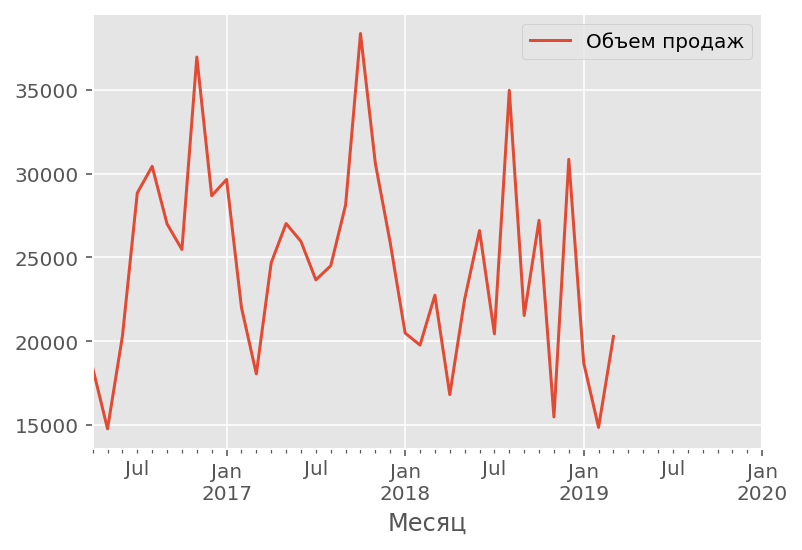

In [63]:
df.plot(x='Месяц');

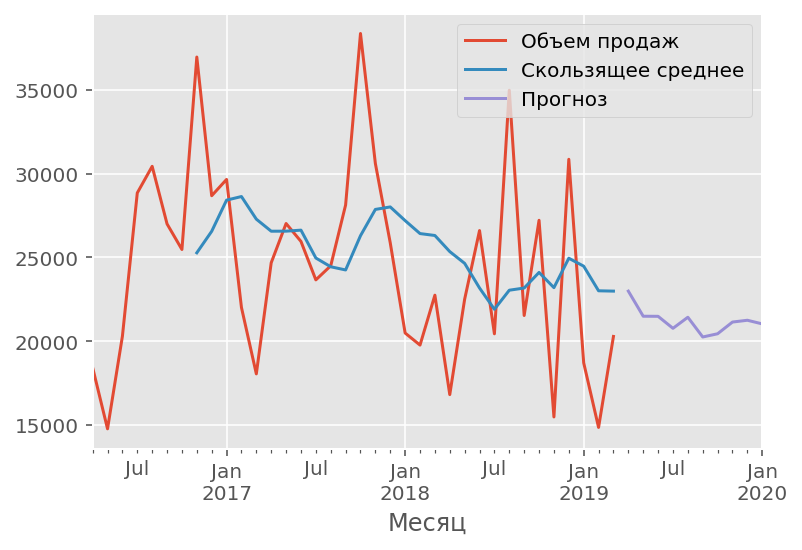

In [64]:
N = 8 #период
df['Скользящее среднее'] = df['Объем продаж'].rolling(N).mean()
forecast = []
y = df['Объем продаж']
non_nan_length = df['Объем продаж'].dropna().index[-1]+1 #сколько имеется данных
for k,i in enumerate(range(non_nan_length,df.shape[0])):
    if N >= k: #когда прогнозы строятся частично на данных, частично на прошлых прогнозах
        el = (y[(i-N):i-k].sum()+sum(forecast))/N
    else: #прогнозы строятся полностью на прошлых прогнозах
        el = sum(forecast[-N:])/N
    forecast.append(el)
        
df['Прогноз'] = [np.nan]*(non_nan_length) + forecast
df.plot(x='Месяц');

При периоде скользящего окна равном 8 среднее не сильно поддается скачкам, но показывает тренд

In [65]:
y_pred = df['Скользящее среднее']
error = np.nanmean(abs(y-y_pred)/y*100)
display(Markdown(f'Относительная ошибка: {error}%'))

Относительная ошибка: 20.25151240067649%

### 2

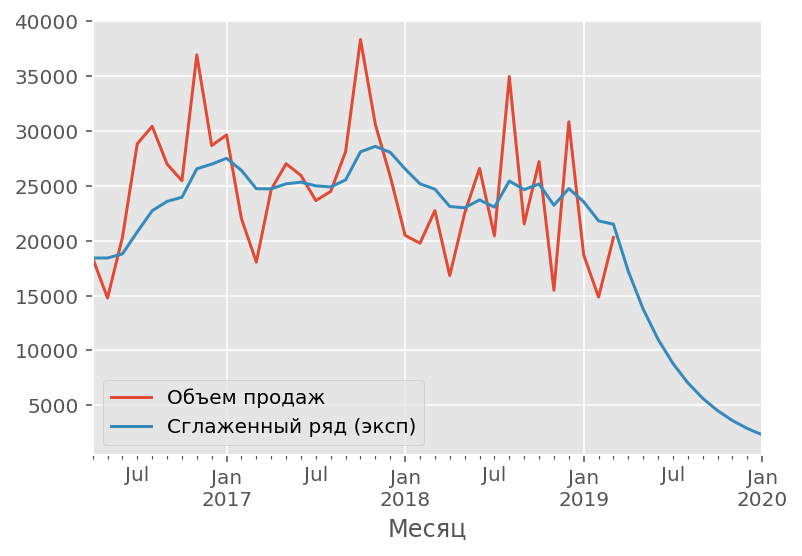

In [70]:
a = 0.2 # параметр сглаживания 

x0 = df['Объем продаж'][0]
S = [x0, a*x0+(1-a)*x0]

for i,x in enumerate(df['Объем продаж'][2:]): 
    if not np.isnan(x):
        S.append(a*x+(1-a)*S[i+1])
    else:
        S.append((1-a)*S[i+1])
        
df['Сглаженный ряд (эксп)'] = S
df[['Месяц','Объем продаж','Сглаженный ряд (эксп)']].plot(x='Месяц');

In [67]:
y_pred = df['Сглаженный ряд (эксп)']
error = np.nanmean(abs(y-y_pred)/y*100)
display(Markdown(f'Относительная ошибка: {error}%'))

Относительная ошибка: 16.55075689798916%

### 3

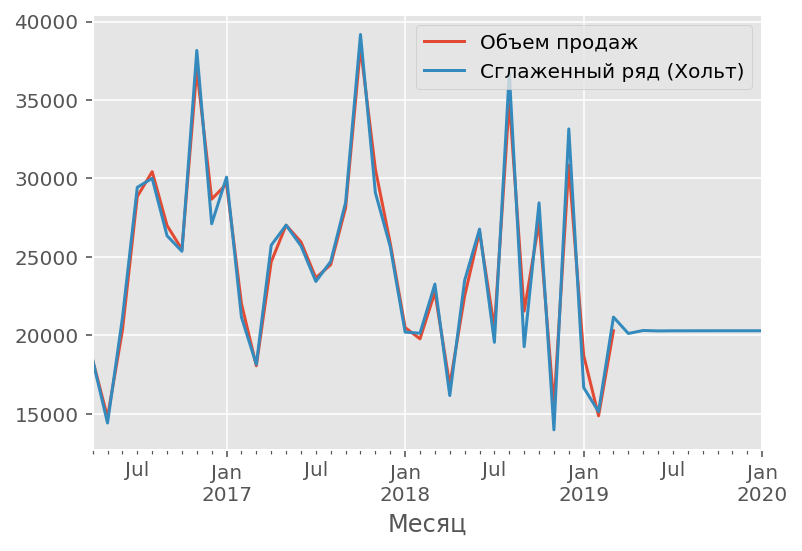

In [68]:
def holt(params,return_loss=True):
    a,b = params
    y = df['Объем продаж']
    x0 = y[0]
    L,T = [x0],[0]
    x_last = y[non_nan_length-1] #последнее известное значение объемов продаж
    for i,x in enumerate(y[1:]): 
        if not np.isnan(x):
            L.append(a*x+(1-a)*(L[i]-T[i]))
            T.append(b*(L[i+1]-L[i])+(1-b)*T[i]) 
        else: #для прогноза
            L.append(a*x_last+(1-a)*(L[i]-T[i]))
            T.append(b*(L[i+1]-L[i])+(1-b)*T[i])
    
    forecast = np.array(L)+np.array(T)
    if return_loss:
        return np.nanmean(([abs(forecast[i]-y[i])/y[i] for i in range(len(y))]))
    else:
        return forecast

best_params = optimize.newton(holt,x0=[0.5,0.5]) #получаем параметры минимизирующие ошибку

df['Сглаженный ряд (Хольт)'] = holt(best_params,return_loss=False)
df[['Месяц','Объем продаж','Сглаженный ряд (Хольт)']].plot(x='Месяц');

In [69]:
display(Markdown(f'Относительная ошибка: {holt(best_params)*100}%'))

Относительная ошибка: 3.246035970506092%

### 4

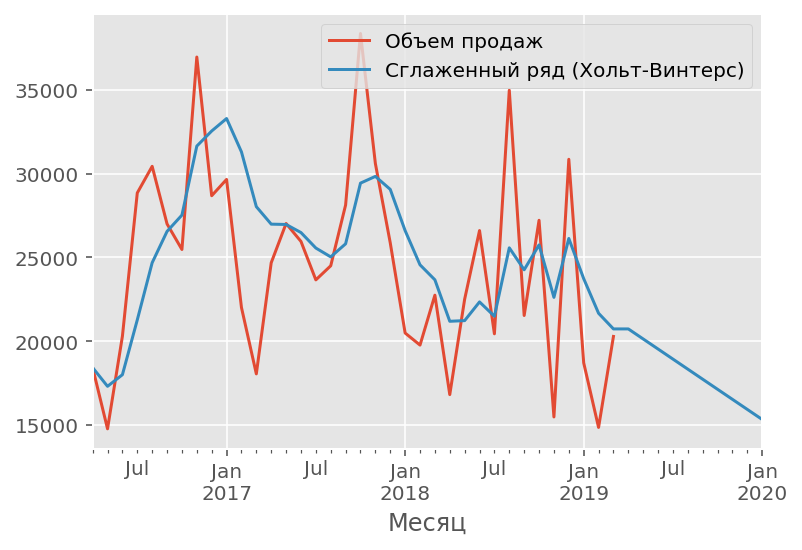

In [47]:
p = 12 #период
def holt_winters(params,return_loss=True):
    a,b,g = params
    
    
    L,T,S = [],[],[1]*p 
    
    for i,x in enumerate(df['Объем продаж']):
        if i == 0:
            L.append(x0)
            L,T = [x0],[0]
        else:
            L.append( a*x/S[i-1] + (1-a)*(L[i-1]+T[i-1]) )
            T.append( b*(L[i]-L[i-1]) + (1-b)*T[i-1] )
        if i >= p:
            S.append( g*x/L[i] + (1-g)*S[i-2])
    
    forecast = np.array(L)+np.array(T)
    for i,_ in enumerate(df['Объем продаж'][non_nan_length:]):
        forecast[non_nan_length+i] = L[non_nan_length-1]+(i+1)*T[non_nan_length-1]
    if return_loss:
        return np.nanmean(([abs(forecast[i]-y[i])/y[i] for i in range(len(y))]))
    else:
        return forecast

best_params = optimize.newton(holt_winters,x0=[0.5,0.5,0.5],maxiter=500) #получаем параметры минимизирующие ошибку

df['Сглаженный ряд (Хольт-Винтерс)'] = holt_winters(best_params,return_loss=False) 
df[['Месяц','Объем продаж','Сглаженный ряд (Хольт-Винтерс)']].plot(x='Месяц');

In [48]:
display(Markdown(f'Относительная ошибка: {holt_winters(best_params)*100}%'))

Относительная ошибка: 16.12437361602139%

### Вывод
Наименьшая ошибка у метода Хольта-Винтерса, однако наиболее правдоподобный прогноз делает метод скользящей средней. Остальные методы либо монотонно убывают, либо стоят на одном значении. Поэтому для всех методов кроме скользящей средней целесообразно делать прогноз лишь на несколько значений вперед. 

## Задания по данным Набор 2

### 1 - по месяцам

In [76]:
df = pd.read_excel('Набор № 2.xlsx')
df.head()

,Unnamed: 0,Unnamed: 1,Продажи
0,2011.0,Январь,3232.16
1,NaN,Февраль,5703.49
2,NaN,Март,3425.66
3,NaN,Апрель,2922.83
4,NaN,Май,6440.50


In [77]:
month_to_numbers ={'Январь':1,'Февраль':2,'Март':3,'Апрель':4,'Май':5,'Июнь':6,'Июль':7,'Август':8,'Сентябрь':9,'Октябрь':10,'Ноябрь':11,'Декабрь':12,np.nan:np.nan}
func = lambda x: month_to_numbers[x]
df = df.rename(columns={'Unnamed: 1':'Номер месяца','Продажи':'Объем продаж'})
df['Номер месяца'] = df['Номер месяца'].map(func)

df = df[['Номер месяца','Объем продаж']]
df.head()

,Номер месяца,Объем продаж
0,1,3232.16
1,2,5703.49
2,3,3425.66
3,4,2922.83
4,5,6440.50


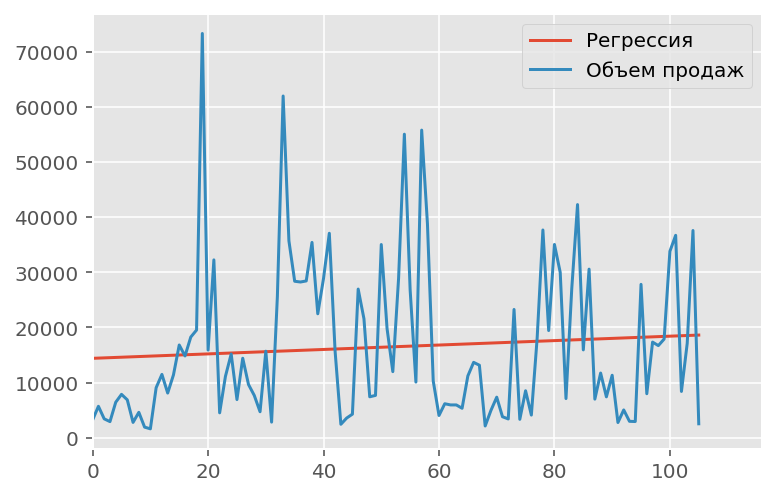

In [78]:
y = df['Объем продаж'].dropna()
x = np.arange(1,y.size+1)
coef1 = np.polyfit(x, y, 1)
f = np.poly1d(coef1)
df['Регрессия'] = pd.Series(f(x))
df[['Регрессия','Объем продаж']].plot();

In [79]:
P = 12 #период
df['Отн ошибка'] = abs(df['Объем продаж']-df['Регрессия'])/df['Объем продаж']*100
seasonality = [] #сезонности
for p in range(1,P+1):
    denominator = len([i for i in range(df.shape[0]) if df['Номер месяца'][i] == p%P+1])
    seasonality.append(np.nansum([(df['Объем продаж'][i]-df['Регрессия'][i])/denominator for i in range(df.shape[0]) if df['Номер месяца'][i] == p]))

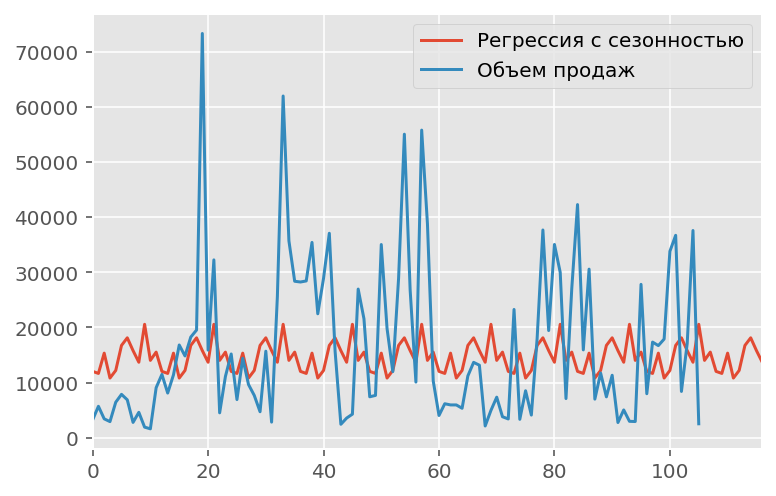

In [80]:
#заполним столбец Номер месяца до конца
non_nan_length = df['Объем продаж'].dropna().index[-1]+1 
last_val = df['Номер месяца'][non_nan_length-1]
df.loc[non_nan_length:,'Номер месяца'] = [p%P+1 for p in range(last_val,last_val+df.shape[0]-non_nan_length)]
#посчитаем прогноз
df['Регрессия с сезонностью'] = [f(i%p+1)+seasonality[i%p] for i,_ in enumerate(df['Регрессия'])]
y_pred = df['Регрессия с сезонностью'][:non_nan_length]
df[['Регрессия с сезонностью','Объем продаж']].plot();

In [54]:
interval = str(st.norm.interval(0.9, loc=df['Объем продаж'].mean(), scale=df['Объем продаж'].std()/(df.shape[0])**.5))
error = sum(abs(y-y_pred)/y)*100
display(Markdown(f'Доверительный интервал: {interval}'))
display(Markdown(f'Относительная ошибка регрессии: {error}%'))

Доверительный интервал: (14336.01449614505, 18684.192210001573)

Относительная ошибка регрессии: 14121.04874931187%

### 1 - по кварталам

In [72]:
df = pd.read_excel('Набор № 2.xlsx')
df = df.rename(columns={'Продажи':'Объем продаж'})
df = df['Объем продаж']
df = df.groupby(lambda x: df.index[x] // 3).sum(min_count=1)
df = pd.DataFrame({'Номер квартала':df.index%4+1,'Объем продаж':df})
df.head()

,Номер квартала,Объем продаж
0,1,12361.31
1,2,17229.83
2,3,14263.99
3,4,12610.74
4,1,30984.76


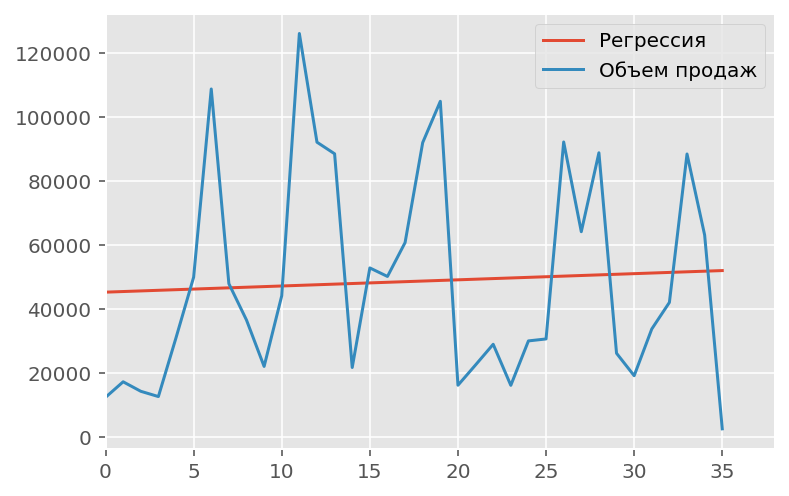

In [73]:
y = df['Объем продаж'].dropna()
x = np.arange(1,y.size+1)
coef1 = np.polyfit(x, y, 1)
f = np.poly1d(coef1)
df['Регрессия'] = pd.Series(f(x))
df[['Регрессия','Объем продаж']].plot();

In [74]:
P = 4 #период
df['Отн ошибка'] = abs(df['Объем продаж']-df['Регрессия'])/df['Объем продаж']*100
seasonality = [] #сезонности
for p in range(1,P+1):
    denominator = len([i for i in range(df.shape[0]) if df['Номер квартала'][i] == p%P+1])
    seasonality.append(np.nansum([(df['Объем продаж'][i]-df['Регрессия'][i])/denominator for i in range(df.shape[0]) if df['Номер квартала'][i] == p]))

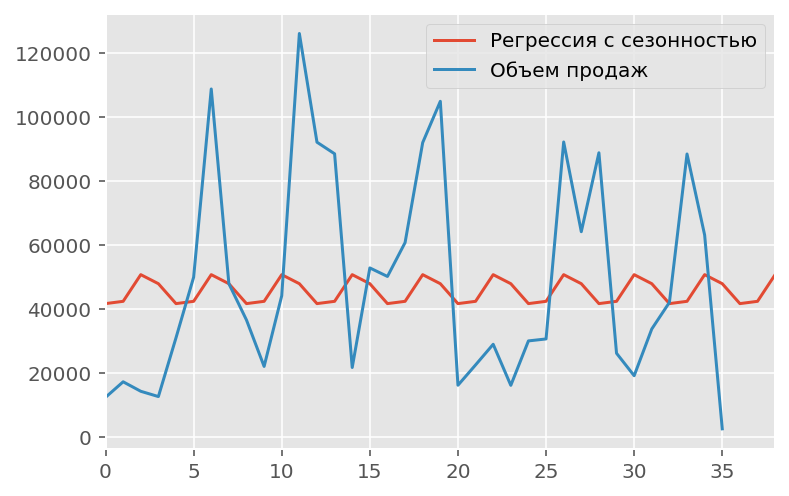

In [75]:
#заполним столбец Номер квартала до конца
non_nan_length = df['Объем продаж'].dropna().shape[0] 
last_val = df['Номер квартала'][non_nan_length-1]
df.loc[non_nan_length:,'Номер квартала'] = [p%P+1 for p in range(last_val,last_val+df.shape[0]-non_nan_length)]
#посчитаем прогноз
df['Регрессия с сезонностью'] = [f(i%p+1)+seasonality[i%p] for i,_ in enumerate(df['Регрессия'])]
y_pred = df['Регрессия с сезонностью'][:non_nan_length]
df[['Регрессия с сезонностью','Объем продаж']].plot();

In [59]:
interval = str(st.norm.interval(0.9, loc=df['Объем продаж'].mean(), scale=df['Объем продаж'].std()/(df.shape[0])**.5))
error = sum(abs(y-y_pred)/y)*100
display(Markdown(f'Доверительный интервал: {interval}'))
display(Markdown(f'Относительная ошибка регрессии: {error}%'))

Доверительный интервал: (39917.10883078556, 57309.05535953506)

Относительная ошибка регрессии: 4455.570653184399%

### Выводы
Сезонность присутствует. Большая ошибка обоих методов объясняется большими колебаниями значений и тем, что методы предсказывают одинаковые значения каждый год (при этом поквартально меньше ошибка, так как там выбросы сглаживаются).

### 2

#### Методы абсолютных и относительных разностей

In [81]:
df = pd.read_excel('Набор № 2.xlsx')
month_to_numbers ={'Январь':1,'Февраль':2,'Март':3,'Апрель':4,'Май':5,'Июнь':6,'Июль':7,'Август':8,'Сентябрь':9,'Октябрь':10,'Ноябрь':11,'Декабрь':12,np.nan:np.nan}
func = lambda x: month_to_numbers[x]
df = df.rename(columns={'Unnamed: 1':'Номер месяца','Продажи':'Объем продаж'})
df['Номер месяца'] = df['Номер месяца'].map(func)

df = df[['Номер месяца','Объем продаж']].dropna()
P = 12
means = [] #средние значения за каждый месяц

for p in range(P):
    means.append(np.mean([df['Объем продаж'][i] for i in range(0+p,df.shape[0],P)]))
    
mean_mean = np.mean(means)
abs_season = [mean-mean_mean for mean in means]
rel_season = [s/mean_mean for s in abs_season]
res1 = ['Сезонность есть' if i > 0 else 'Сезонности нет' for i in abs_season]
res2 = ['Сезонность есть' if i > 0 else 'Сезонности нет' for i in rel_season]
pd.DataFrame({'Абс':abs_season,'Вывод1':res1,'Отн':rel_season,'Вывод2':res2}, index=pd.Index(range(1,P+1),name='Месяц'))

,Абс,Вывод1,Отн,Вывод2
Месяц,,,,
1,-2811.80,Сезонности нет,-0.17,Сезонности нет
2,-3227.51,Сезонности нет,-0.20,Сезонности нет
3,854.34,Сезонность есть,0.05,Сезонность есть
4,-4171.07,Сезонности нет,-0.25,Сезонности нет
5,-2640.09,Сезонности нет,-0.16,Сезонности нет
6,2398.44,Сезонность есть,0.15,Сезонность есть
7,3926.48,Сезонность есть,0.24,Сезонность есть
8,1341.09,Сезонность есть,0.08,Сезонность есть
9,-1004.42,Сезонности нет,-0.06,Сезонности нет


#### Индексный подход

In [82]:
means_year = [[]] #средние значения за каждый год
current_year = 0
last_month = -1
for i,month in enumerate(df['Номер месяца']):
    if month > last_month:
        means_year[current_year].append(df['Объем продаж'][i])
        last_month = month
    else:
        means_year.append([df['Объем продаж'][i]])
        last_month = month
        current_year += 1
means_year = [np.mean(year) for year in means_year]
ls1 = []
for p in range(P):
    ls1.append(np.mean([df['Объем продаж'][i]/means_year[i//P]*100 for i in range(0+p,df.shape[0],P)])-100)
ls2 = [mean/mean_mean*100-100 for mean in means]
res = [] #выводы
for i,j in zip(ls1,ls2):
    if i > 0 and j > 0:
        res.append('Сезонность есть')
    elif i < 0 and j < 0:
        res.append('Сезонности нет')
    else:
        res.append('Нельзя сделать вывод')

pd.DataFrame({'Ls1*':ls1,'Ls2*':ls2,'Вывод':res}, index=pd.Index(range(1,P+1),name='Месяц'))

,Ls1*,Ls2*,Вывод
Месяц,,,
1,-12.45,-17.03,Сезонности нет
2,-13.16,-19.55,Сезонности нет
3,1.88,5.17,Сезонность есть
4,-27.28,-25.26,Сезонности нет
5,-12.18,-15.99,Сезонности нет
6,19.10,14.53,Сезонность есть
7,27.10,23.78,Сезонность есть
8,7.06,8.12,Сезонность есть
9,-8.81,-6.08,Сезонности нет


### 3 - аддитивная модель

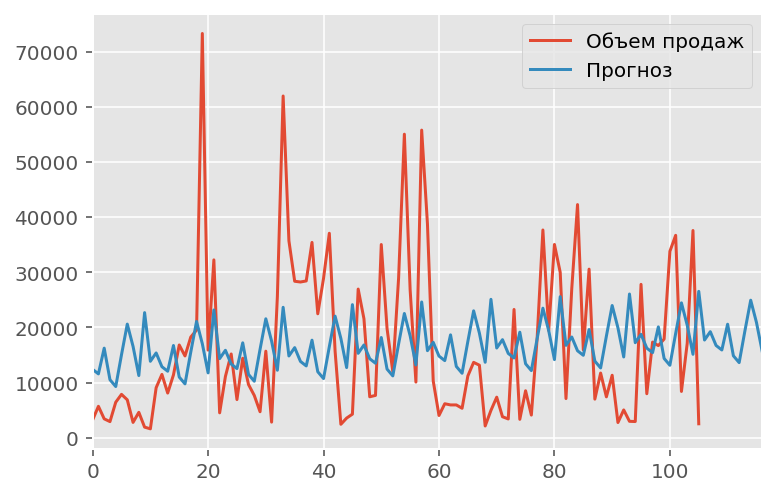

In [83]:
P = 12
df = pd.read_excel('Набор № 2.xlsx')
month_to_numbers ={'Январь':1,'Февраль':2,'Март':3,'Апрель':4,'Май':5,'Июнь':6,'Июль':7,'Август':8,'Сентябрь':9,'Октябрь':10,'Ноябрь':11,'Декабрь':12,np.nan:np.nan}
func = lambda x: month_to_numbers[x]
df = df.rename(columns={'Unnamed: 1':'Номер месяца','Продажи':'Объем продаж'})
df['Номер месяца'] = df['Номер месяца'].map(func)
df = df[['Номер месяца','Объем продаж']]

roll =  df['Объем продаж'].rolling(P).mean()
c_roll = roll.rolling(2).mean().shift(-P//2)
s_vars_est = df['Объем продаж']-c_roll #оценки сезонных вариаций
s_vars_mean = np.array([np.nanmean(s_vars_est[i::P]) for i in range(P)])
s_vars = s_vars_mean-sum(s_vars_mean)/P

non_nan_length = df['Объем продаж'].dropna().shape[0]
df.loc[non_nan_length:,'Номер месяца'] = [p%P+1 for p in range(last_val,last_val+df.shape[0]-non_nan_length)]
df['Сезонная вариация'] = [s_vars[i-1] for i in df['Номер месяца']]

y = df['Объем продаж'].dropna()
x = np.arange(y.size)
coef1 = np.polyfit(x, y, 1)
f = np.poly1d(coef1)

df['Прогноз'] = f(df.index)+df['Сезонная вариация']
df[['Объем продаж','Прогноз']].plot();

In [84]:
y = df['Объем продаж']
y_pred = df['Прогноз']
error = np.nanmean(abs(y-y_pred)/y*100)
display(Markdown(f'Относительная ошибка регрессии: {error}%'))

Относительная ошибка регрессии: 150.7298409927712%

### 3 - мультипликативная модель

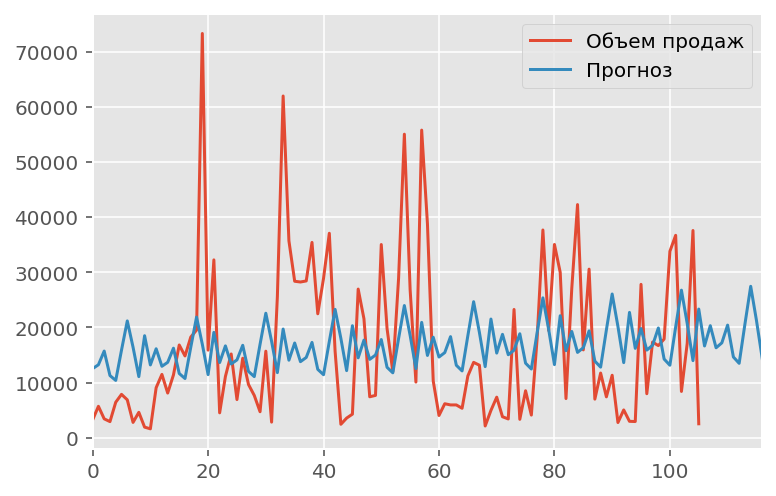

In [85]:
P = 12
df = pd.read_excel('Набор № 2.xlsx')
month_to_numbers ={'Январь':1,'Февраль':2,'Март':3,'Апрель':4,'Май':5,'Июнь':6,'Июль':7,'Август':8,'Сентябрь':9,'Октябрь':10,'Ноябрь':11,'Декабрь':12,np.nan:np.nan}
func = lambda x: month_to_numbers[x]
df = df.rename(columns={'Unnamed: 1':'Номер месяца','Продажи':'Объем продаж'})
df['Номер месяца'] = df['Номер месяца'].map(func)
df = df[['Номер месяца','Объем продаж']]

roll =  df['Объем продаж'].rolling(P).mean()
c_roll = roll.rolling(2).mean().shift(-P//2)
s_vars_est = df['Объем продаж'] /c_roll #оценки сезонных вариаций
s_vars_mean = np.array([np.nanmean(s_vars_est[i::P]) for i in range(P)])
s_vars = s_vars_mean*P/sum(s_vars_mean)

non_nan_length = df['Объем продаж'].dropna().shape[0]
last_val = df['Номер месяца'][non_nan_length-1]
df.loc[non_nan_length:,'Номер месяца'] = [p%P+1 for p in range(last_val,last_val+df.shape[0]-non_nan_length)]
df['Сезонная вариация'] = [s_vars[i-1] for i in df['Номер месяца']]

y = df['Объем продаж'].dropna()
x = np.arange(y.size)
coef1 = np.polyfit(x, y, 1)
f = np.poly1d(coef1)

df['Прогноз'] = f(df.index)*df['Сезонная вариация']
df[['Объем продаж','Прогноз']].plot();

In [86]:
y = df['Объем продаж']
y_pred = df['Прогноз']
error = np.nanmean(abs(y-y_pred)/y*100)
display(Markdown(f'Относительная ошибка регрессии: {error}%'))

Относительная ошибка регрессии: 146.04532621104028%

## Задания по данным Набор 3

In [87]:
pd.set_option('precision', 2)
df = pd.read_excel('Набор № 3.xlsx')
df

,Компания,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-03-01 00:00:00,2020-04-01 00:00:00
0,Асна,1285.20,2570.40,3855.60,3277.26,1413.72,2184.84,4241.16
1,Вита,2184.84,3854.71,6039.55,5133.62,2403.32,3276.50,6643.51
2,Доктор Столетов,4623.16,1991.17,6614.33,5622.18,5085.48,1692.49,7275.76
3,Невис,2763.18,7839.72,10602.90,9012.47,3039.50,6663.76,11663.19
4,Нео-фарм,5783.40,NaN,5783.40,4915.89,6361.74,NaN,6361.74
5,Опека,NaN,899.64,899.64,764.69,NaN,764.69,989.60
6,Горздрав,385.56,192.78,578.34,491.59,424.12,163.86,636.17
7,Ригла,7684.50,5462.10,13146.60,11174.61,8452.95,4642.79,14461.26
8,Живика,385.56,NaN,385.56,327.73,424.12,NaN,424.12
9,36и6,642.60,1285.20,1927.80,1638.63,706.86,1092.42,2120.58


### 1 - ABC

In [88]:
def abc(arr):
    res = []
    for x in arr:
        if x <= 80:
            res.append('A')
        elif x <= 95:
            res.append('B')
        else:
            res.append('C')
    return res

df['Прибыль'] = [df.iloc[i,1:].sum() for i in range(df.shape[0])]
df['%'] = df['Прибыль']/df['Прибыль'].sum()*100
df = df.sort_values('%',ascending=False)
df['Накопленный %'] = np.cumsum(df['%'])
df['ABC'] = abc(df['Накопленный %'])
df[['Компания','Прибыль','%','Накопленный %','ABC']]

,Компания,Прибыль,%,Накопленный %,ABC
7,Ригла,65024.81,26.47,26.47,A
3,Невис,51584.72,21.00,47.47,A
2,Доктор Столетов,32904.58,13.40,60.87,A
1,Вита,29536.05,12.02,72.89,A
4,Нео-фарм,29206.17,11.89,84.78,B
0,Асна,18828.18,7.67,92.45,B
9,36и6,9414.09,3.83,96.28,C
5,Опека,4318.27,1.76,98.04,C
6,Горздрав,2872.42,1.17,99.21,C
8,Живика,1947.08,0.79,100.00,C


A - компания имеет значительную долю рынка

B - компания имеет среднюю долю рынка

C - компания имеет малую долю рынка

### 2 - XYZ

In [89]:
def abc(arr):
    res = []
    for x in arr:
        if x < 10:
            res.append('X')
        elif x < 25:
            res.append('Y')
        else:
            res.append('Z')
    return res


df['Коэффициент вариации'] = [df.iloc[i,1:8].std()/df.iloc[i,1:8].mean()*100 for i in range(df.shape[0])]
df = df.sort_values('Коэффициент вариации')
df['XYZ'] = abc(df['Коэффициент вариации'])
df[['Компания','Коэффициент вариации','XYZ']]

,Компания,Коэффициент вариации,XYZ
8,Живика,10.15,Y
4,Нео-фарм,10.15,Y
5,Опека,11.29,Y
7,Ригла,40.45,Z
1,Вита,41.60,Z
0,Асна,42.88,Z
9,36и6,42.88,Z
6,Горздрав,43.90,Z
2,Доктор Столетов,45.70,Z
3,Невис,47.10,Z


X - у компании стабильный спрос

Y - у компании периодичные, сезонный спрос

Z - у компании случайный спрос

### ABC+XYZ

In [90]:
combined_lists = [['','',''], 
                 ['','',''],
                 ['','','']] #матрица ABC на XYZ
abc_dict = {'A':0,'B':1,'C':2}
xyz_dict = {'X':0,'Y':1,'Z':2}
for _,el in df[['Компания','ABC','XYZ']].iterrows():
    name,a,x = el
    combined_lists[abc_dict[a]][xyz_dict[x]] += ', '+name
df_ax = pd.DataFrame(combined_lists,columns=['X','Y','Z'],index=['A','B','C'])
df_ax = df_ax.applymap(lambda x: x[2:])
df_ax

,X,Y,Z
A,,,"Ригла, Вита, Доктор Столетов, Невис"
B,,Нео-фарм,Асна
C,,"Живика, Опека","36и6, Горздрав"


Компании AZ имеют значительную долю рынка при случайном доходе

Компании BZ имеют среднюю долю рынка при случайном доходе

Компании YZ имеют малую долю рынка при случайном доходе

Компании BY имеют среднюю долю рынка при сезонном доходе

Компании CY имеют малую долю рынка при сезонном доходе

Среди имеющихся компаний заслуживающими наибольшее внимание являются компании BY (Нео-фарм) и AZ (Ригла, Вита, Доктор Столетов, Невис)